# Example: Opening large remote datasets

```{note}
The online laboratory has only been tested in recent Firefox and Chrome browsers. Some features may not (yet) be supported in Safari browsers.
```

```{caution}
In the online laboratory, changes to notebooks and local files are only saved in your web browser's storage and not persisted to disk.

Please download copies of any files that you don't want to lose.

Your files from an old session will usually be kept if you close or refresh this page, unless your browser's storage for `lab.climet.eu` is cleared, e.g.
- manually by clearing the browser's site data
- automatically when too much data is stored
- automatically when you close a private browsing context
- if you have setup your browser to clear site data, e.g. when the browser is closed
```

## Motivation

Datasets in weather and climate modelling can easily exceed the size of your machine's working memory or even file storage. It is thus increasingly important to work with remotely stored datasets that are streamed-in as needed. Instead of downloading the entire dataset up-front, only the dataset metadata (e.g. information about the variables in the dataset) is downloaded immediately. The actual data is only fetched when it is requested by the user, e.g. by inspecting the data values, visualising a variable, or computing the mean value over a subslice of the data. Note that even when such a request for data occurs, care is taken to only load the minimum data needed to satisfy the request, and to stream it in small chunks instead of downloading it all in one go.

## Installing `fsspec`, `kerchunk`, and `zarr`

Zarr is a modern dataset format that is specifically designed for chunked access. It supports loading datasets from any filesystem implementing the `fsspec` API, e.g. local or remote HTTP or S3 filesystems. The `kerchunk` package helps with utilising the power of `fsspec` &#10084; `zarr` for non-Zarr datasets, including NetCDF (and GRIB with pre-processing).

In [1]:
import aiohttp
import dask
import earthkit.plots
import earthkit.plots.quickmap
import fsspec
import gribscan
import kerchunk
import s3fs
import xarray as xr
import zarr

[pyodide]: Loading Cartopy, Jinja2, MarkupSafe, Pillow, adjustText, affine, aiobotocore, aiohappyeyeballs, aiohttp, aioitertools, aiosignal, asciitree, astropy, astropy_iers_data, async-timeout, attrs, botocore, cdsapi, cffi, cfgrib, cftime, click, cligj, cloudpickle, cycler, dask, datapi, earthkit, earthkit-data, earthkit-geo, earthkit-meteo, earthkit-plots, earthkit-plots-default-styles, earthkit-regrid, earthkit-time, earthkit-transforms, eccodes, ecmwf-api-client, ecmwf-opendata, entrypoints, filelock, findlibs, fiona, flexcache, flexparser, fonttools, frozenlist, fsspec, gdal, geopandas, geos, gribscan, h5py, healpy, importlib_metadata, jmespath, jsonschema, jsonschema_specifications, kerchunk, kiwisolver, locket, lru-dict, markdown, matplotlib, matplotlib-pyodide, msgpack, multidict, multiurl, netcdf4, numcodecs, numpy, openblas, pandas, partd, pdbufr, pint, pkgconfig, platformdirs, plotly, propcache, pyarrow, pycparser, pyerfa, pyodide-unix-timezones, pyparsing, pyproj, pyrsiste

/lib/python3.12/site-packages/earthkit/regrid/utils/caching.py:27: UserWarning: only soft file lock is available
  from filelock import FileLock


[pyodide]: Memory usage has grown to 356.2MiB (from 49.9MiB) for this notebook


We also import a utility module `utils.py` from the outer parent directory.

In [2]:
import sys
sys.path.insert(0, "..")

In [3]:
import utils

[pyodide]: Loading ipyfilite, ipywidgets, jupyterlab_widgets, mpmath, sympy, widgetsnbextension
[pyodide]: Loaded ipyfilite, ipywidgets, jupyterlab_widgets, mpmath, sympy, widgetsnbextension


We also install the `humanize` package so that we can later pretty-print the size of the remotely opened datasets.

In [4]:
%pip install humanize
import humanize

In [5]:
dask.config.set(array__chunk_size="4MiB");

## Opening a remote Zarr dataset

First, we open a remote Zarr dataset via HTTPS:

In [6]:
ds = xr.open_dataset(
    "https://noaa-nwm-retro-v2-zarr-pds.s3.amazonaws.com", engine="zarr", chunks=dict(),
)
ds

<xarray.Dataset> Size: 35TB
Dimensions:         (time: 227904, feature_id: 2729077)
Coordinates:
  * feature_id      (feature_id) int32 11MB 101 179 ... 1180001803 1180001804
    latitude        (feature_id) float32 11MB dask.array<chunksize=(2729077,), meta=np.ndarray>
    longitude       (feature_id) float32 11MB dask.array<chunksize=(2729077,), meta=np.ndarray>
  * time            (time) datetime64[ns] 2MB 1993-01-01 ... 2018-12-31T23:00:00
Data variables:
    elevation       (time, feature_id) float32 2TB dask.array<chunksize=(672, 30000), meta=np.ndarray>
    order           (time, feature_id) int32 2TB dask.array<chunksize=(672, 30000), meta=np.ndarray>
    qBtmVertRunoff  (time, feature_id) float64 5TB dask.array<chunksize=(672, 30000), meta=np.ndarray>
    qBucket         (time, feature_id) float64 5TB dask.array<chunksize=(672, 30000), meta=np.ndarray>
    qSfcLatRunoff   (time, feature_id) float64 5TB dask.array<chunksize=(672, 30000), meta=np.ndarray>
    q_lateral       (time, feature_id) float64 5TB dask.array<chunksize=(672, 30000), meta=np.ndarray>
    streamflow      (time, feature_id) float64 5TB dask.array<chunksize=(672, 30000), meta=np.ndarray>
    velocity        (time, feature_id) float64 5TB dask.array<chunksize=(672, 30000), meta=np.ndarray>
Attributes: (12/17)
    Conventions:                CF-1.6
    cdm_datatype:               Station
    code_version:               v5.1.0-alpha11
    dev:                        dev_ prefix indicates development/internal me...
    dev_NOAH_TIMESTEP:          3600
    dev_OVRTSWCRT:              1
    ...                         ...
    model_output_type:          channel_rt
    model_output_valid_time:    2018-12-28_00:00:00
    model_total_valid_times:    2208
    proj4:                      +proj=lcc +units=m +a=6370000.0 +b=6370000.0 ...
    station_dimension:          feature_id
    stream_order_output:        1

Since this particular dataset is stored in an S3 bucket, we could have also used an S3 filesystem directly:

In [7]:
ds = xr.open_dataset(
    "s3://noaa-nwm-retro-v2-zarr-pds", engine="zarr", chunks=dict(),
    backend_kwargs=dict(storage_options=dict(anon=True)),
)
ds

<xarray.Dataset> Size: 35TB
Dimensions:         (time: 227904, feature_id: 2729077)
Coordinates:
  * feature_id      (feature_id) int32 11MB 101 179 ... 1180001803 1180001804
    latitude        (feature_id) float32 11MB dask.array<chunksize=(2729077,), meta=np.ndarray>
    longitude       (feature_id) float32 11MB dask.array<chunksize=(2729077,), meta=np.ndarray>
  * time            (time) datetime64[ns] 2MB 1993-01-01 ... 2018-12-31T23:00:00
Data variables:
    elevation       (time, feature_id) float32 2TB dask.array<chunksize=(672, 30000), meta=np.ndarray>
    order           (time, feature_id) int32 2TB dask.array<chunksize=(672, 30000), meta=np.ndarray>
    qBtmVertRunoff  (time, feature_id) float64 5TB dask.array<chunksize=(672, 30000), meta=np.ndarray>
    qBucket         (time, feature_id) float64 5TB dask.array<chunksize=(672, 30000), meta=np.ndarray>
    qSfcLatRunoff   (time, feature_id) float64 5TB dask.array<chunksize=(672, 30000), meta=np.ndarray>
    q_lateral       (time, feature_id) float64 5TB dask.array<chunksize=(672, 30000), meta=np.ndarray>
    streamflow      (time, feature_id) float64 5TB dask.array<chunksize=(672, 30000), meta=np.ndarray>
    velocity        (time, feature_id) float64 5TB dask.array<chunksize=(672, 30000), meta=np.ndarray>
Attributes: (12/17)
    Conventions:                CF-1.6
    cdm_datatype:               Station
    code_version:               v5.1.0-alpha11
    dev:                        dev_ prefix indicates development/internal me...
    dev_NOAH_TIMESTEP:          3600
    dev_OVRTSWCRT:              1
    ...                         ...
    model_output_type:          channel_rt
    model_output_valid_time:    2018-12-28_00:00:00
    model_total_valid_times:    2208
    proj4:                      +proj=lcc +units=m +a=6370000.0 +b=6370000.0 ...
    station_dimension:          feature_id
    stream_order_output:        1

After loading the dataset, which may take a few minutes, we can inspect its metadata and variables and verify its large size.

In [8]:
print(f"ds.nbytes = {humanize.naturalsize(ds.nbytes, binary=True)}")

ds.nbytes = 31.7 TiB


Note that even inspecting variable or creating a slice does not immediately request any data but instead just operates on the variable's metadata.

In [9]:
ds["velocity"]

<xarray.DataArray 'velocity' (time: 227904, feature_id: 2729077)> Size: 5TB
dask.array<open_dataset-velocity, shape=(227904, 2729077), dtype=float64, chunksize=(672, 30000), chunktype=numpy.ndarray>
Coordinates:
  * feature_id  (feature_id) int32 11MB 101 179 181 ... 1180001803 1180001804
    latitude    (feature_id) float32 11MB dask.array<chunksize=(2729077,), meta=np.ndarray>
    longitude   (feature_id) float32 11MB dask.array<chunksize=(2729077,), meta=np.ndarray>
  * time        (time) datetime64[ns] 2MB 1993-01-01 ... 2018-12-31T23:00:00
Attributes:
    grid_mapping:  crs
    long_name:     River Velocity
    units:         ms-1
    valid_range:   [0, 50000000]

At this point, only the metadata of the dataset is stored in memory. The data values of the array will only be streamed in once we request them, e.g. by accessing the `values` attribute of the variable (slice):

In [10]:
ds["velocity"][:10,:10].values

array([[0.08      , 0.14      , 0.14      , 0.03      , 0.03      ,
        0.06      , 0.11      , 0.26999999, 0.28999999, 0.2       ],
       [0.08      , 0.14      , 0.14      , 0.03      , 0.03      ,
        0.06      , 0.11      , 0.26999999, 0.28999999, 0.2       ],
       [0.08      , 0.14      , 0.14      , 0.03      , 0.03      ,
        0.06      , 0.11      , 0.26999999, 0.28999999, 0.2       ],
       [0.08      , 0.14      , 0.14      , 0.03      , 0.03      ,
        0.06      , 0.11      , 0.26999999, 0.28999999, 0.2       ],
       [0.08      , 0.14      , 0.14      , 0.03      , 0.03      ,
        0.06      , 0.11      , 0.26999999, 0.28999999, 0.2       ],
       [0.08      , 0.14      , 0.14      , 0.03      , 0.03      ,
        0.06      , 0.11      , 0.26999999, 0.28999999, 0.2       ],
       [0.08      , 0.14      , 0.14      , 0.03      , 0.03      ,
        0.06      , 0.11      , 0.26999999, 0.28999999, 0.2       ],
       [0.08      , 0.14      , 0.14     

[pyodide]: Memory usage has grown to 863.4MiB (from 356.2MiB) for this notebook


## Opening a remote NetCDF dataset

The NetCDF format also supports streaming its data. Here, we want to use the power of `zarr` with a remotely hosted NetCDF dataset.

First, we use `kerchunk` to fetch the chunking metadata for a remote NetCDF dataset via HTTPS and to translate it into a Zarr-compatible format. We then apply the

```python
utils.kerchunk_autochunk(kc: dict, *, chunk_size: int) -> dict
```
helper function to automatically chunk the `kerchunk`-loaded dataset such that every chunk is at most `chunk_size` bytes large.

In [11]:
import kerchunk.hdf

kc = kerchunk.hdf.SingleHdf5ToZarr(
    "https://a3s.fi/compression.lab.climet.eu/HighResMIP_6h_reduced_pl_t.nc",
    inline_threshold=0, error="raise", storage_options=dict(block_size=512),
).translate()

kc = utils.kerchunk_autochunk(kc, chunk_size=2**22)  # 4MiB

After the conversion has completed, which may take a minute, we can open the dataset using Zarr:

In [12]:
ds = xr.open_dataset(
    "reference://", engine="zarr", backend_kwargs=dict(
        storage_options=dict(fo=kc),
    ), consolidated=False, chunks=dict(),
)
ds

<xarray.Dataset> Size: 20GB
Dimensions:              (cell: 6599680, nvertex: 4, pressure_levels: 19,
                          time_counter: 20, axis_nbounds: 2)
Coordinates:
    lat                  (cell) float32 26MB dask.array<chunksize=(824960,), meta=np.ndarray>
    lon                  (cell) float32 26MB dask.array<chunksize=(824960,), meta=np.ndarray>
  * pressure_levels      (pressure_levels) float32 76B 1e+05 9.25e+04 ... 100.0
  * time_counter         (time_counter) datetime64[ns] 160B 2009-10-15T18:00:...
    time_instant         (time_counter) datetime64[ns] 160B dask.array<chunksize=(1,), meta=np.ndarray>
Dimensions without coordinates: cell, nvertex, axis_nbounds
Data variables:
    bounds_lat           (cell, nvertex) float32 106MB dask.array<chunksize=(206240, 4), meta=np.ndarray>
    bounds_lon           (cell, nvertex) float32 106MB dask.array<chunksize=(206240, 4), meta=np.ndarray>
    t                    (time_counter, pressure_levels, cell) float64 20GB dask.array<chunksize=(1, 1, 412480), meta=np.ndarray>
    time_counter_bounds  (time_counter, axis_nbounds) datetime64[ns] 320B dask.array<chunksize=(1, 2), meta=np.ndarray>
    time_instant_bounds  (time_counter, axis_nbounds) datetime64[ns] 320B dask.array<chunksize=(1, 2), meta=np.ndarray>
Attributes:
    Conventions:  CF-1.6
    description:  Created by xios
    name:         HighResMIP_6h_reduced_pl_t
    timeStamp:    2024-Apr-05 11:05:13 GMT
    title:        Created by xios
    uuid:         a5c32cec-37b8-49cc-bde8-cc04f2279d4a

After loading the dataset, we can inspect its metadata and variables and verify its large size.

In [13]:
print(f"ds.nbytes = {humanize.naturalsize(ds.nbytes, binary=True)}")

ds.nbytes = 18.9 GiB


Note that even inspecting variable or creating a slice does not immediately request any data but instead just operates on the variable's metadata.

In [14]:
ds["t"]

<xarray.DataArray 't' (time_counter: 20, pressure_levels: 19, cell: 6599680)> Size: 20GB
dask.array<open_dataset-t, shape=(20, 19, 6599680), dtype=float64, chunksize=(1, 1, 412480), chunktype=numpy.ndarray>
Coordinates:
    lat              (cell) float32 26MB dask.array<chunksize=(824960,), meta=np.ndarray>
    lon              (cell) float32 26MB dask.array<chunksize=(824960,), meta=np.ndarray>
  * pressure_levels  (pressure_levels) float32 76B 1e+05 9.25e+04 ... 100.0
  * time_counter     (time_counter) datetime64[ns] 160B 2009-10-15T18:00:00 ....
    time_instant     (time_counter) datetime64[ns] 160B dask.array<chunksize=(1,), meta=np.ndarray>
Dimensions without coordinates: cell
Attributes:
    cell_methods:        time: point
    interval_operation:  6 h
    interval_write:      6 h
    long_name:           temperature
    online_operation:    instant
    standard_name:       air_temperature
    units:               K

At this point, only the metadata of the dataset is stored in memory. The data values of the array will only be streamed in once we request them, e.g. by accessing the `values` attribute of the variable (slice):

In [15]:
ds["t"][:2, :2, :10].values

array([[[263.40517198, 263.42814901, 263.44936419, 263.46693394,
         263.4795639 , 263.48691854, 263.48951936, 263.48797143,
         263.48207581, 263.47062646],
        [263.26139479, 263.23130788, 263.19385379, 263.15260127,
         263.11252696, 263.07885051, 263.05588428, 263.04620513,
         263.05037622, 263.06733049]],

       [[264.75515573, 264.87320114, 264.94528026, 264.96253324,
         264.93121055, 264.86723462, 264.78821846, 264.70725971,
         264.63061958, 264.55893116],
        [262.22296366, 262.27007024, 262.29859419, 262.3072605 ,
         262.29656567, 262.26837826, 262.22556472, 262.17163671,
         262.11076081, 262.04783023]]])

We finally plot a slice of the dataset. `earthkit` provides the

```python
earthkit.plots.quickmap.plot(
    data, units=None, style=None, **kwargs,
) -> earthkit.plots.components.maps.Map
```

helper function to plot weather and climate maps data.

Here, we plot the a subset of the temperature on 15.10.2009 at 18:00 on the 1000 hPa pressure level:

/lib/python3.12/site-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/50m_physical/ne_50m_coastline.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)


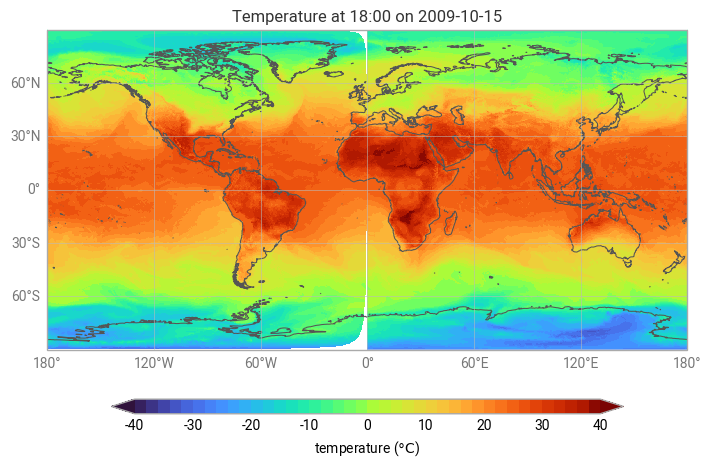

In [16]:
earthkit.plots.quickmap.plot(
    ds["t"].rename(dict(time_counter="time")).sel(
        time="2009-10-15T18:00:00", pressure_levels=1e5,
    )[::10], units="degC", x="lon", y="lat",
);

## Opening a remote pre-processed GRIB dataset

The GRIB format, unlike NetCDF or Zarr, does not store its metadata separately and thus requires a scan of the full dataset to extract its chunking metadata. Since this scanning is costly, it has to be completed offline, e.g. using the `gribscan` or the `kerchunk` package. Once the chunking metadata has been extracted, it is possible to open a remotely hosted GRIB dataset with the power of `zarr`.

In [17]:
ds = xr.open_dataset(
    f"reference::https://a3s.fi/compression.lab.climet.eu/hplp_ml_reduced_gg_all_params_levels_1-15_all_steps.grib.ref",
    engine="zarr", consolidated=False,
)
ds

<xarray.Dataset> Size: 12GB
Dimensions:  (time: 21, level: 15, value: 654400)
Coordinates:
    lat      (value) float64 5MB ...
  * level    (level) int64 120B 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15
    lon      (value) float64 5MB ...
  * time     (time) datetime64[ns] 168B 2020-07-21 ... 2020-07-31
Dimensions without coordinates: value
Data variables:
    cc       (time, level, value) float64 2GB ...
    ciwc     (time, level, value) float64 2GB ...
    clwc     (time, level, value) float64 2GB ...
    crwc     (time, level, value) float64 2GB ...
    cswc     (time, level, value) float64 2GB ...
    o3       (time, level, value) float64 2GB ...
    q        (time, level, value) float64 2GB ...
Attributes:
    GRIB_edition:            2
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    history:                 🪄🧙‍♂️🔮 magic dataset assembly provided by gribsc...

After loading the dataset, we can inspect its metadata and variables and verify its large size.

In [18]:
print(f"ds.nbytes = {humanize.naturalsize(ds.nbytes, binary=True)}")

ds.nbytes = 10.8 GiB


Note that even inspecting variable or creating a slice does not immediately request any data but instead just operates on the variable's metadata.

In [19]:
ds["q"]

<xarray.DataArray 'q' (time: 21, level: 15, value: 654400)> Size: 2GB
[206136000 values with dtype=float64]
Coordinates:
    lat      (value) float64 5MB ...
  * level    (level) int64 120B 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15
    lon      (value) float64 5MB ...
  * time     (time) datetime64[ns] 168B 2020-07-21 ... 2020-07-31
Dimensions without coordinates: value
Attributes: (12/24)
    GRIB_paramId:                          133
    GRIB_dataType:                         fc
    GRIB_numberOfPoints:                   654400
    GRIB_typeOfLevel:                      hybrid
    GRIB_stepUnits:                        1
    GRIB_stepType:                         instant
    ...                                    ...
    GRIB_productDefinitionTemplateNumber:  0
    GRIB_N:                                400
    GRIB_timeRangeIndicator:               0
    GRIB_pl:                               [20, 24, 28, 32, 36, 40, 44, 48, 5...
    units:                                 kg kg**-1
    long_name:                             Specific humidity

At this point, only the metadata of the dataset is stored in memory. The data values of the array will only be streamed in once we request them, e.g. by accessing the `values` attribute of the variable (slice):

In [20]:
ds["q"][:2, :2, :10].values

array([[[2.93476387e-06, 2.93421090e-06, 2.93357061e-06, 2.93295943e-06,
         2.93255198e-06, 2.93249377e-06, 2.93295943e-06, 2.93383255e-06,
         2.93514222e-06, 2.93651010e-06],
        [4.10368193e-06, 4.10368193e-06, 4.10304165e-06, 4.10234315e-06,
         4.10181929e-06, 4.10152825e-06, 4.10094617e-06, 4.09995664e-06,
         4.09919994e-06, 4.09879249e-06]],

       [[2.95233963e-06, 2.95259383e-06, 2.95272571e-06, 2.95278414e-06,
         2.95278687e-06, 2.95271411e-06, 2.95249356e-06, 2.95219252e-06,
         2.95178847e-06, 2.95130167e-06],
        [4.04330331e-06, 4.04273669e-06, 4.04294133e-06, 4.04415459e-06,
         4.04609864e-06, 4.04879938e-06, 4.05195078e-06, 4.05532637e-06,
         4.05849460e-06, 4.06123263e-06]]])

We finally plot a slice of the dataset. `earthkit` provides the

```python
earthkit.plots.quickmap.plot(
    data, units=None, style=None, **kwargs,
) -> earthkit.plots.components.maps.Map
```

helper function to plot weather and climate maps data.

Here, we plot the specific humidity (the percentage of the air weight that water contributes) on 21.07.2020 at 12:00 on the first model level:

[pyodide]: Memory usage has grown to 994.3MiB (from 863.4MiB) for this notebook


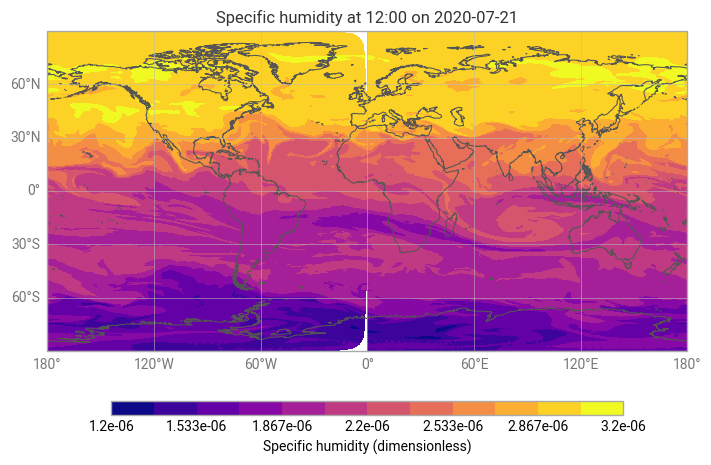

In [21]:
earthkit.plots.quickmap.plot(
    ds["q"].sel(level=1).sel(time="2020-07-21T12:00:00"),
    x="lon", y="lat",
);